In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense


In [2]:

# Generate data for the Monte Carlo simulation
def generate_data(T, N, R2_x, R2_y, seed_val):

    # Set random seed to reproduce same results
    np.random.seed(seed_val)

    # Generate random normal factors 
    f1 = np.random.normal(0, 1, T)
    f2 = np.random.normal(0, 1, T)

    # Generate random means for the variables with normal distr.
    mu1 = np.random.normal(0, 1, N)
    mu2 = np.random.normal(0, 1, N)

    # Generate noise with variance adjusted for R2_x
    eta = np.random.normal(0, np.sqrt(1 - R2_x), (T, N))

    # Generate the x data matrix
    x = np.outer(f1, mu1) + np.outer(f2, mu2) + eta
    x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)

    # Generate noise for the response variables
    epsilon = np.random.normal(0, np.sqrt(1 - R2_y), T)

    # Generate response variables with different structures as explained in the main text
    y_linear = f1 + f2 + epsilon
    y_squared = f1**2 + f2**2 + epsilon
    y_cross = f1 * f2 + epsilon

    return x, y_linear, y_squared, y_cross

# Method to do forecasting using lin. regression
def forecast(y, factors, lags=6):
    # Create lag variables for regression model
    X = np.column_stack([np.roll(factors, i, axis=0) for i in range(1, lags+1)])
    X = X[lags:] #Remove first lags rows to align it with Y 
    y = y[lags:] # Adjust y to match lagged x 
    X = sm.add_constant(X) # adds constant term for the regr. term
    model = sm.OLS(y, X).fit() #fitting ols regresison model
    return model.predict(X) #return the predicted value

# Method to calculate rmspe
def calculate_rmspe(y_true, y_pred):
    return np.mean((y_true - y_pred)**2) / np.var(y_true)

# Method to select number of components based on min BIC
def select_components_bic(x, y, max_components=10):
    min_bic = np.inf
    best_factors = None

    #iterate over number of components from 1 to max_components
    for n in range(1, max_components + 1):
        pca = PCA(n_components=n) # performs pca with n components
        factors = pca.fit_transform(x) #transforms x using pca
        y_pred = forecast(y, factors) # forecasts using pca factors
        bic = sm.OLS(y[6:], sm.add_constant(factors[6:])).fit().bic #calculates bic

        # update best factors if the current bic is lower
        if bic < min_bic:
            min_bic = bic
            best_factors = factors
    return best_factors

# Method to get the constant forecast
def constant_forecast(y):
    return np.mean(y)

# Method to build and train an autoencoder
def build_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

# Method to get factors from autoencoder
def autoencoder_factors(x, encoding_dim=6, epochs=50, batch_size=10):
    input_dim = x.shape[1]
    autoencoder = build_autoencoder(input_dim, encoding_dim)
    autoencoder.fit(x, x, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=0)
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
    factors = encoder.predict(x)
    return factors

# Run monte carlo simulation and model evaluation
def simulate_and_evaluate(T, N, R2_x_values, R2_y_values, models, num_simulations, seed_val=0):
    results = []

    # looping through each combination of R2_x and R2_y value
    for R2_x in R2_x_values:
        for R2_y in R2_y_values:
            for sim in range(num_simulations):

                # generate data for the current simulation
                x, y_linear, y_squared, y_cross = generate_data(T, N, R2_x, R2_y, seed_val + sim)

                looping throughe ach model
                for model in models:
                    if model == 'PCA':
                        factors = select_components_bic(x, y_linear)
                    elif model == 'SPCA':
                        factors = select_components_bic(np.hstack([x, x**2]), y_linear)
                    elif model == 'PCA2':
                        factors = select_components_bic(x, y_linear)
                        factors = np.hstack([factors, factors**2])
                    elif model == 'KPCApoly':
                        factors = KernelPCA(n_components=6, kernel='poly', degree=2).fit_transform(x)
                    elif model == 'KPCAsigmoid':
                        factors = KernelPCA(n_components=6, kernel='sigmoid').fit_transform(x)
                    elif model == 'KPCArbf':
                        factors = KernelPCA(n_components=6, kernel='rbf').fit_transform(x)
                    elif model == 'Autoencoder':
                        factors = autoencoder_factors(x)
                    elif model == 'Constant':

                        # performing constant forecast
                        y_pred_linear = np.full_like(y_linear[6:], constant_forecast(y_linear))
                        y_pred_squared = np.full_like(y_squared[6:], constant_forecast(y_squared))
                        y_pred_cross = np.full_like(y_cross[6:], constant_forecast(y_cross))

                        # gets the results for constant forecast
                        results.append({
                            'Model': model,
                            'R2_x': R2_x,
                            'R2_y': R2_y,
                            'Linear': calculate_rmspe(y_linear[6:], y_pred_linear),
                            'Squared': calculate_rmspe(y_squared[6:], y_pred_squared),
                            'Cross': calculate_rmspe(y_cross[6:], y_pred_cross)
                        })
                        continue

                    # performing forecasts for the model
                    y_pred_linear = forecast(y_linear, factors)
                    y_pred_squared = forecast(y_squared, factors)
                    y_pred_cross = forecast(y_cross, factors)

                    # results for the current model and simulation 

                    results.append({
                        'Model': model,
                        'R2_x': R2_x,
                        'R2_y': R2_y,
                        'Linear': calculate_rmspe(y_linear[6:], y_pred_linear),
                        'Squared': calculate_rmspe(y_squared[6:], y_pred_squared),
                        'Cross': calculate_rmspe(y_cross[6:], y_pred_cross)
                    })
    return results




In [3]:
# Parameters, time horizon and defining the values of R2_x and R2_y
T = 120
N = 100
R2_x_values = [0.4, 0.8]
R2_y_values = [0.4, 0.8]
models = ['PCA', 'SPCA', 'PCA2', 'KPCApoly', 'KPCAsigmoid', 'KPCArbf', 'Autoencoder', 'Constant']
num_simulations = 5000

# Simulations and get result of the simulation
results = simulate_and_evaluate(T, N, R2_x_values, R2_y_values, models, num_simulations)



4/4 [==============================] - 0s 3ms/step


                         Linear   Squared     Cross
Model       R2_x R2_y                              
Autoencoder 0.4  0.4   0.687973  0.696579  0.683118
                 0.8   0.683722  0.684403  0.684944
            0.8  0.4   0.691913  0.691917  0.687165
                 0.8   0.690733  0.695015  0.686321
Constant    0.4  0.4   1.000592  1.000645  1.000615
                 0.8   1.000566  1.000673  1.000645
            0.8  0.4   1.000592  1.000645  1.000615
                 0.8   1.000566  1.000673  1.000645
KPCApoly    0.4  0.4   0.690309  0.687589  0.681241
                 0.8   0.690041  0.688529  0.681785
            0.8  0.4   0.689292  0.689288  0.682944
                 0.8   0.689242  0.690443  0.683343
KPCArbf     0.4  0.4   0.682638  0.687234  0.683730
                 0.8   0.686185  0.688901  0.682553
            0.8  0.4   0.681312  0.687810  0.683376
                 0.8   0.684912  0.690126  0.681848
KPCAsigmoid 0.4  0.4   0.686256  0.686579  0.682176
            

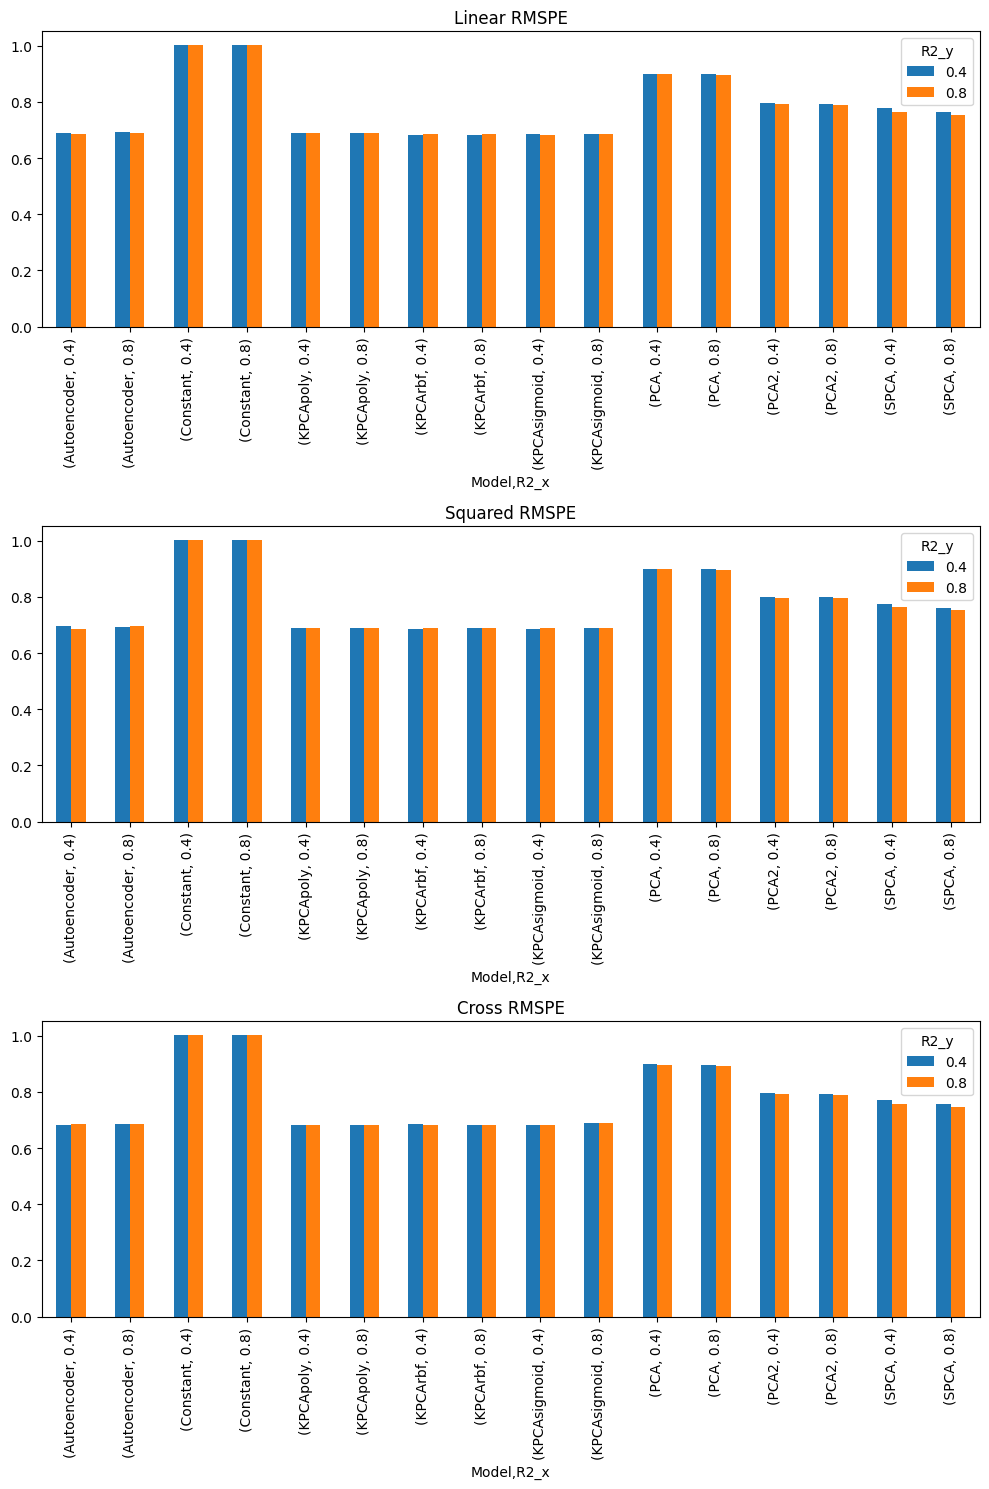

In [4]:
# Converting to dataframe
results_df = pd.DataFrame(results)
results_summary = results_df.groupby(['Model', 'R2_x', 'R2_y']).mean()
print(results_summary)

# Plot the results of every dgp method
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
results_summary['Linear'].unstack().plot(kind='bar', ax=axes[0], title='Linear RMSPE')
results_summary['Squared'].unstack().plot(kind='bar', ax=axes[1], title='Squared RMSPE')
results_summary['Cross'].unstack().plot(kind='bar', ax=axes[2], title='Cross RMSPE')

plt.tight_layout()
plt.show()